In [1]:
# Multimodal search
# Searching through an open source image dataset using an open source model called CLIP.
# This model is able to encode the images and the text in the same embedding space, allowing us to retrieve images that are similar to a user question/context

In [2]:
# Setup CLIP model
# 1. a model to encode the image
# 2. a processor to prepare the image to be encoded

from transformers import CLIPModel, CLIPProcessor

MODEL_ID = "openai/clip-vit-base-patch32"
device = "cpu"

model = CLIPModel.from_pretrained(MODEL_ID).to(device)
processor = CLIPProcessor.from_pretrained(MODEL_ID, use_fast=True)

/home/sriramramesh/miniconda3/envs/genai/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Setup data model
import io

from lancedb.pydantic import LanceModel, vector
import PIL


class Image(LanceModel):
    image: bytes
    label: int
    vector: vector(512)  # type: ignore

    def to_pil(self):
        return PIL.Image.open(io.BytesIO(self.image))

    @classmethod
    def pil_to_bytes(cls, img) -> bytes:
        buf = io.BytesIO()
        img.save(buf, format="PNG")
        return buf.getvalue()

In [4]:
# Image processing function
# Implement a function to process batches of data from the dataset.
# Will be using the zh-plus/tiny-imagenet dataset from huggingface datasets.
def process_image(batch: dict) -> dict:
    image = processor(text=None, images=batch["image"], return_tensors="pt")[
        "pixel_values"
    ].to(device)
    img_emb = model.get_image_features(image)
    batch["vector"] = img_emb.cpu()
    batch["image_bytes"] = [Image.pil_to_bytes(img) for img in batch["image"]]
    return batch

In [5]:
# Table creation
import lancedb

db = lancedb.connect(".lancedb")
TABLE_NAME = "image_search"
db.drop_table(TABLE_NAME, ignore_missing=True)
table = db.create_table(TABLE_NAME, schema=Image.to_arrow_schema())

In [6]:
# Adding data to the table
# Now process the images and generate embeddings
# The following function calls process_image on each image in the validation set (10K images) and return a list of Image instances.

from datasets import load_dataset

def datagen() -> list[Image]:
    dataset = load_dataset("zh-plus/tiny-imagenet")['valid']
    return [
        Image(image=b["image_bytes"], label=b["label"], vector=b["vector"])
        for b in dataset.map(process_image, batched=True, batch_size=64)
    ]

In [7]:
data = datagen()
table.add(data)

/home/sriramramesh/miniconda3/envs/genai/lib/python3.9/site-packages/dill/_dill.py:422: PicklingWarning: Cannot locate reference to <class '__main__.Image'>.
  StockPickler.save(self, obj, save_persistent_id)
/home/sriramramesh/miniconda3/envs/genai/lib/python3.9/site-packages/dill/_dill.py:422: PicklingWarning: Cannot pickle <class '__main__.Image'>: __main__.Image has recursive self-references that trigger a RecursionError.
  StockPickler.save(self, obj, save_persistent_id)
Map: 100%|██████████| 10000/10000 [02:20<00:00, 71.01 examples/s]


AddResult(version=2)

In [8]:
len(table)

10000

In [9]:
# Encoding user queries
# Generate the embedding for the user query
from transformers import CLIPTokenizerFast

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
tokenizer = CLIPTokenizerFast.from_pretrained(MODEL_ID)

def embed_func(query):
    inputs = tokenizer([query], padding=True, return_tensors="pt")
    text_features = model.get_text_features(**inputs)
    return text_features.detach().numpy()[0]

In [10]:
# Search function
# Find image that takes the text query as input and returns a list of PIL images that's most similar to the query.
def find_images(query):
    emb = embed_func(query)
    rs = table.search(emb).limit(9).to_pydantic(Image)
    return [m.to_pil() for m in rs]

In [11]:
images = find_images("fish")

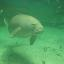

In [12]:
images[0]

In [13]:
import gradio as gr

with gr.Blocks() as demo:
    gr.Markdown("## Text to Image Search")

    user_prompt = gr.Textbox(label="Enter your search query")
    submit_btn = gr.Button("Submit")

    gallery = gr.Gallery(
        label="Images",
        show_label=False,
        elem_id="gallery",
        columns=3,
        height="auto",
        type="pil"
    )

    submit_btn.click(fn=find_images, inputs=user_prompt, outputs=gallery)

In [ ]:

demo.launch(share=True)

In [15]:
demo.close()

Closing server running on port: 7860
